# LSTM Model dla prognozowania cen akcji

Ten notebook zawiera implementację modelu LSTM (Long Short-Term Memory) do prognozowania cen akcji.

## 1. Import bibliotek

In [37]:
## 1. Import i przygotowanie
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import Dict, List, Tuple, Optional, Union, Any
import warnings
warnings.filterwarnings('ignore')

sys.path.append('..')

from src.lstm_model import LSTMModel, LSTMTrainer, prepare_data_for_lstm, TimeSeriesDataset
from src.utils import create_directories, evaluate_model, print_metrics, save_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Używane urządzenie: {device}")

Używane urządzenie: cuda


## 2. Wczytanie danych

In [38]:
data_path = r"C:\Users\pawli\OneDrive\Pulpit\sieci\Projektowanie_i_zastosowania_sieci_neuronowych\data\data\processed\cleaned_data.csv"

if os.path.exists(data_path):
    print(f"✅ Znaleziono plik: {data_path}")
    df = pd.read_csv(data_path)
    
    # Konwersja Date jeśli potrzeba
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    
    print(f"Liczba wierszy w danych: {len(df)}")
    print(f"Kolumny: {df.columns.tolist()}")
    
    # Sprawdź czy mamy kolumnę Close/Last
    if 'Close/Last' not in df.columns and 'Close' in df.columns:
        df['Close/Last'] = df['Close']
        print("ℹ️ Utworzono kolumnę Close/Last z kolumny Close")
    
    df.head()
else:
    print(f"❌ Nie znaleziono pliku: {data_path}")
    print("Sprawdź ścieżkę!")

✅ Znaleziono plik: C:\Users\pawli\OneDrive\Pulpit\sieci\Projektowanie_i_zastosowania_sieci_neuronowych\data\data\processed\cleaned_data.csv
Liczba wierszy w danych: 2623
Kolumny: ['Date', 'Open', 'High', 'Low', 'Close/Last', 'Volume']


## 3. Dodanie prostych cech technicznych

In [39]:
# Sortowanie
df = df.sort_values('Date').reset_index(drop=True)

# Podstawowe transformacje
df['Returns'] = df['Close/Last'].pct_change()
df['Log_Returns'] = np.log(df['Close/Last'] / df['Close/Last'].shift(1))

# Cechy względne (nie absolutne!)
df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=10).mean()
df['Daily_Range'] = (df['High'] - df['Low']) / df['Close/Last']
df['Price_Position'] = (df['Close/Last'] - df['Low']) / (df['High'] - df['Low'] + 1e-8)

# Średnie kroczące - jako ratio, nie wartości
df['MA_5'] = df['Close/Last'].rolling(window=5).mean()
df['MA_20'] = df['Close/Last'].rolling(window=20).mean()
df['Price_MA5_Ratio'] = df['Close/Last'] / df['MA_5']
df['Price_MA20_Ratio'] = df['Close/Last'] / df['MA_20']

# Momentum
df['Momentum_5'] = df['Close/Last'] / df['Close/Last'].shift(5) - 1
df['Momentum_10'] = df['Close/Last'] / df['Close/Last'].shift(10) - 1

# Volatility
df['Volatility_5'] = df['Returns'].rolling(window=5).std()
df['Volatility_20'] = df['Returns'].rolling(window=20).std()

# TARGET - następny zwrot!
df['Target_Return'] = df['Returns'].shift(-1)

# Usuń NaN
df = df.dropna()

print(f"Liczba wierszy po dodaniu cech: {len(df)}")
print(f"Nowe cechy: {[col for col in df.columns if col not in ['Date', 'Close/Last', 'Open', 'High', 'Low', 'Volume']]}")


Liczba wierszy po dodaniu cech: 2602
Nowe cechy: ['Returns', 'Log_Returns', 'Volume_Ratio', 'Daily_Range', 'Price_Position', 'MA_5', 'MA_20', 'Price_MA5_Ratio', 'Price_MA20_Ratio', 'Momentum_5', 'Momentum_10', 'Volatility_5', 'Volatility_20', 'Target_Return']


## 4. Przygotowanie danych dla modelu LSTM

In [40]:
# Używaj tylko cech względnych
feature_cols = [
    'Returns',
    'Volume_Ratio',
    'Daily_Range', 
    'Price_Position',
    'Price_MA5_Ratio',
    'Price_MA20_Ratio',
    'Momentum_5',
    'Momentum_10',
    'Volatility_5',
    'Volatility_20'
]

target_col = 'Target_Return'  # ✅ Przewiduj zwroty!

# Przygotowanie danych
data = prepare_data_for_lstm(
    df=df,
    feature_cols=feature_cols,
    target_col=target_col,
    seq_length=30,
    test_size=0.2,
    val_size=0.1,
    batch_size=64,
    shuffle=False   # ✅ Zawsze False dla danych czasowych!
)

print(f"Liczba cech: {data['input_size']}")
print(f"Liczba próbek treningowych: {len(data['X_train'])}")
print(f"Liczba próbek walidacyjnych: {len(data['X_val'])}")
print(f"Liczba próbek testowych: {len(data['X_test'])}")

Liczba cech: 10
Liczba próbek treningowych: 1800
Liczba próbek walidacyjnych: 257
Liczba próbek testowych: 515


## 5. Modyfikacja klasy trenera dla lepszej wydajności

In [41]:
class ImprovedLSTMTrainer(LSTMTrainer):
    """Rozszerzona wersja trenera z lepszymi strategiami."""
    
    def __init__(self, model, learning_rate=0.001, weight_decay=1e-5, device=None):
        super().__init__(model, learning_rate, weight_decay, device)
        
        # Zmiana na Huber Loss - mniej wrażliwy na outliers
        self.criterion = nn.HuberLoss()
        
        # Dodanie schedulera do learning rate
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
    
    def train_epoch(self, train_loader):
        """Trenowanie z gradient clipping."""
        self.model.train()
        total_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            
            # Forward pass
            y_pred = self.model(X_batch)
            loss = self.criterion(y_pred, y_batch)
            
            # Backpropagation z gradient clipping
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            
        return total_loss / len(train_loader)
    
    def fit(self, train_loader, val_loader, epochs, early_stopping_patience=10, verbose=True):
        """Trenowanie ze schedulerem."""
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model_state = None
        
        for epoch in range(epochs):
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            # Scheduler step
            self.scheduler.step(val_loss)
            
            if verbose and epoch % 10 == 0:
                print(f'Epoka {epoch+1}/{epochs}, Strata treningowa: {train_loss:.6f}, '
                      f'Strata walidacyjna: {val_loss:.6f}')
            
            # Early stopping z zapisem najlepszego modelu
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
                best_model_state = self.model.state_dict().copy()
            else:
                epochs_without_improvement += 1
                
            if epochs_without_improvement >= early_stopping_patience:
                if verbose:
                    print(f'Early stopping po {epoch+1} epokach')
                break
        
        # Przywróć najlepszy model
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            
        return {
            'train_loss': self.train_losses,
            'val_loss': self.val_losses
        }

## 6. Definicja ulepszonego modelu LSTM

In [42]:
# Parametry modelu - zwiększone wartości
input_size = data['input_size']
hidden_size = 64  # Zwiększone z 64
num_layers = 2    # Zwiększone z 2
output_size = 1
dropout = 0.3      # Zwiększone z 0.2

# Inicjalizacja modelu
lstm_model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout
)

lstm_model = lstm_model.to(device)
print(f"Parametry modelu: {sum(p.numel() for p in lstm_model.parameters()):,}")


Parametry modelu: 52,801


## 5. Trenowanie modelu LSTM

In [43]:
# Inicjalizacja ulepszonego trenera
trainer = ImprovedLSTMTrainer(
    model=lstm_model,
    learning_rate=0.001,  # Zmniejszone z 0.001
    weight_decay=1e-4,     # Zwiększone dla lepszej regularyzacji
    device=device
)

# Parametry trenowania
epochs = 150  # Zwiększone ze 100
early_stopping_patience = 20  # Zwiększone z 15

print("Rozpoczynam trenowanie z ulepszeniami:")
print("- Huber Loss zamiast MSE")
print("- Learning rate scheduler")
print("- Gradient clipping")
print("- Więcej cech technicznych")
print("- Dłuższa sekwencja (30 dni)")

# Trenowanie modelu
history = trainer.fit(
    train_loader=data['train_loader'],
    val_loader=data['val_loader'],
    epochs=epochs,
    early_stopping_patience=early_stopping_patience,
    verbose=True
)

Rozpoczynam trenowanie z ulepszeniami:
- Huber Loss zamiast MSE
- Learning rate scheduler
- Gradient clipping
- Więcej cech technicznych
- Dłuższa sekwencja (30 dni)
Epoka 1/150, Strata treningowa: 0.026972, Strata walidacyjna: 0.004491
Epoka 11/150, Strata treningowa: 0.001713, Strata walidacyjna: 0.001938
Epoka 21/150, Strata treningowa: 0.001603, Strata walidacyjna: 0.001937
Early stopping po 29 epokach


## 6. Analiza wyników treningu

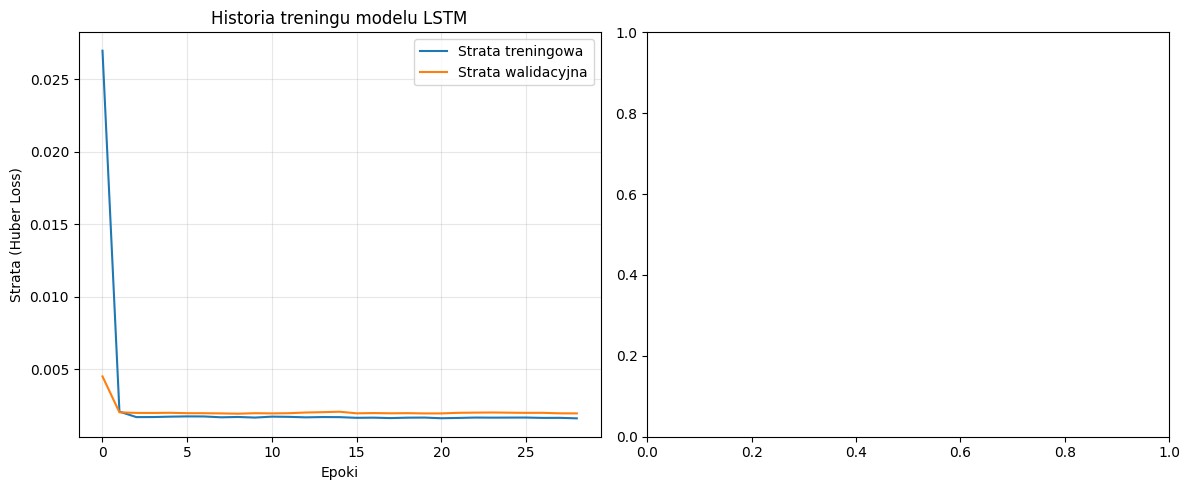

In [44]:
plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Strata treningowa')
plt.plot(history['val_loss'], label='Strata walidacyjna')
plt.title('Historia treningu modelu LSTM')
plt.xlabel('Epoki')
plt.ylabel('Strata (Huber Loss)')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom na ostatnie 50 epok
plt.subplot(1, 2, 2)
if len(history['train_loss']) > 50:
    plt.plot(history['train_loss'][-50:], label='Strata treningowa')
    plt.plot(history['val_loss'][-50:], label='Strata walidacyjna')
    plt.title('Ostatnie 50 epok')
    plt.xlabel('Epoki')
    plt.ylabel('Strata (Huber Loss)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Predykcja na zbiorze testowym

In [45]:
# Konwersja zwrotów na ceny dla wizualizacji
# WAŻNE: Musimy znaleźć dokładny indeks gdzie zaczynają się dane testowe
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.1)
test_start_idx = train_size + val_size + 30  # +30 bo seq_length

# Pobierz rzeczywiste ceny dla okresu testowego
test_indices = range(test_start_idx, test_start_idx + len(y_test_returns))
actual_prices = df['Close/Last'].iloc[test_indices].values

# Sprawdź czy długości się zgadzają
print(f"\nDługość y_test_returns: {len(y_test_returns)}")
print(f"Długość actual_prices: {len(actual_prices)}")

# Oblicz przewidywane ceny używając zwrotów
initial_price = actual_prices[0]  # Startujemy od pierwszej rzeczywistej ceny testowej
predicted_prices = [initial_price]

for i in range(len(y_pred_returns)):
    # Używamy przewidywanych zwrotów do obliczenia następnej ceny
    next_price = predicted_prices[-1] * (1 + y_pred_returns[i][0])
    predicted_prices.append(next_price)

predicted_prices = np.array(predicted_prices[1:])  # Usuń początkową cenę

# Sprawdź długości
if len(predicted_prices) != len(actual_prices):
    print(f"⚠️ Niezgodność długości: predicted={len(predicted_prices)}, actual={len(actual_prices)}")
    # Dopasuj do krótszej długości
    min_len = min(len(predicted_prices), len(actual_prices))
    predicted_prices = predicted_prices[:min_len]
    actual_prices = actual_prices[:min_len]
    print(f"Dopasowano do długości: {min_len}")

# Oblicz metryki na cenach
mse_prices = mean_squared_error(actual_prices, predicted_prices)
rmse_prices = np.sqrt(mse_prices)
mae_prices = np.mean(np.abs(actual_prices - predicted_prices))
r2_prices = r2_score(actual_prices, predicted_prices)

print("\n=== METRYKI NA CENACH ===")
print(f"MSE: {mse_prices:.2f}")
print(f"RMSE: {rmse_prices:.2f}")
print(f"MAE: {mae_prices:.2f}")
print(f"R²: {r2_prices:.3f}")

# DODAJ TĘ SEKCJĘ PO "print("\n=== METRICS ON PRICES ===")"

# Sprawdzenie czy model nie przewiduje stałej wartości
print("\n=== WALIDACJA PREDYKCJI ===")
print(f"Średnia przewidywanych zwrotów: {np.mean(y_pred_returns):.6f}")
print(f"Std przewidywanych zwrotów: {np.std(y_pred_returns):.6f}")
print(f"Min przewidywanych zwrotów: {np.min(y_pred_returns):.6f}")
print(f"Max przewidywanych zwrotów: {np.max(y_pred_returns):.6f}")

print(f"\nŚrednia rzeczywistych zwrotów: {np.mean(y_test_returns):.6f}")
print(f"Std rzeczywistych zwrotów: {np.std(y_test_returns):.6f}")

# Ostrzeżenie jeśli model przewiduje zbyt małą wariancję
if np.std(y_pred_returns) < 0.5 * np.std(y_test_returns):
    print("\n⚠️ UWAGA: Model przewiduje zbyt małą zmienność!")
    print("To może oznaczać, że model przewiduje wartości bliskie średniej.")
    
# Sprawdź czy przewidywane ceny rosną liniowo
price_diffs = np.diff(predicted_prices)
if np.std(price_diffs) < 0.1 * np.mean(np.abs(price_diffs)):
    print("\n⚠️ UWAGA: Przewidywane ceny wyglądają na liniowe!")
    print("Model prawdopodobnie nie uchwycił zmienności rynku.")


Długość y_test_returns: 491
Długość actual_prices: 491

=== METRYKI NA CENACH ===
MSE: 618.44
RMSE: 24.87
MAE: 20.44
R²: 0.831

=== WALIDACJA PREDYKCJI ===
Średnia przewidywanych zwrotów: 0.000720
Std przewidywanych zwrotów: 0.000695
Min przewidywanych zwrotów: -0.001093
Max przewidywanych zwrotów: 0.002890

Średnia rzeczywistych zwrotów: 0.000742
Std rzeczywistych zwrotów: 0.010347

⚠️ UWAGA: Model przewiduje zbyt małą zmienność!
To może oznaczać, że model przewiduje wartości bliskie średniej.


## 8. Wizualizacja predykcji

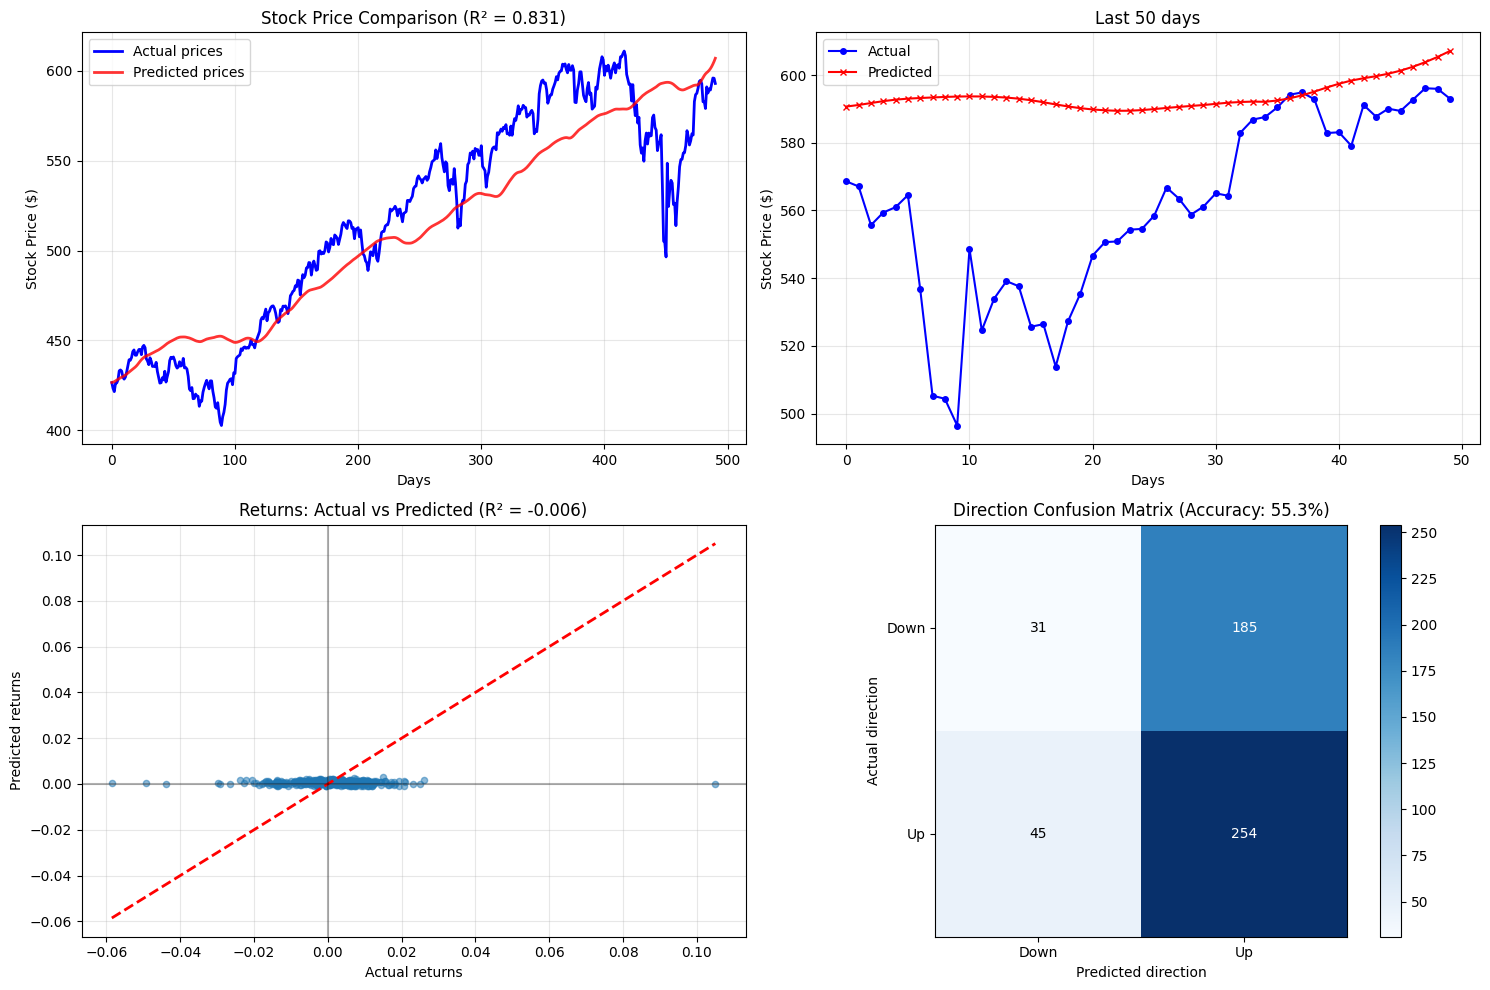


=== RESULTS ANALYSIS ===
1. Direction accuracy: 55.3% ✅
2. R² on prices: 0.831 ✅
3. R² on returns: -0.006 (typical: -0.01 to 0.1 for daily data)
4. Price RMSE: $24.87

✅ Model predicts direction better than random!
⚠️ Model has difficulties predicting returns.


In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Price comparison (converted from returns)
axes[0, 0].plot(actual_prices, label='Actual prices', color='blue', linewidth=2)
axes[0, 0].plot(predicted_prices, label='Predicted prices', color='red', alpha=0.8, linewidth=2)
axes[0, 0].set_title(f'Stock Price Comparison (R² = {r2_prices:.3f})')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Stock Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Last 50 days
n_last = min(50, len(actual_prices))
axes[0, 1].plot(range(n_last), actual_prices[-n_last:], 'bo-', label='Actual', markersize=4)
axes[0, 1].plot(range(n_last), predicted_prices[-n_last:], 'rx-', label='Predicted', markersize=4)
axes[0, 1].set_title(f'Last {n_last} days')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Stock Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot of returns (not prices!)
axes[1, 0].scatter(y_test_returns, y_pred_returns, alpha=0.5, s=20)
axes[1, 0].plot([y_test_returns.min(), y_test_returns.max()],
                [y_test_returns.min(), y_test_returns.max()], 'r--', lw=2)
axes[1, 0].set_title(f'Returns: Actual vs Predicted (R² = {r2_returns:.3f})')
axes[1, 0].set_xlabel('Actual returns')
axes[1, 0].set_ylabel('Predicted returns')
axes[1, 0].grid(True, alpha=0.3)

# Add quadrant information
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# 4. Direction movement analysis
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual_direction, pred_direction)

# Confusion matrix plot
im = axes[1, 1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1, 1].figure.colorbar(im, ax=axes[1, 1])
axes[1, 1].set(xticks=np.arange(2),
               yticks=np.arange(2),
               xticklabels=['Down', 'Up'],
               yticklabels=['Down', 'Up'],
               title=f'Direction Confusion Matrix (Accuracy: {direction_accuracy:.1%})',
               ylabel='Actual direction',
               xlabel='Predicted direction')

# Add values to matrix
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        axes[1, 1].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Additional analysis
print("\n=== RESULTS ANALYSIS ===")
print(f"1. Direction accuracy: {direction_accuracy:.1%} {'✅' if direction_accuracy > 0.5 else '❌'}")
print(f"2. R² on prices: {r2_prices:.3f} {'✅' if r2_prices > 0 else '❌'}")
print(f"3. R² on returns: {r2_returns:.3f} (typical: -0.01 to 0.1 for daily data)")
print(f"4. Price RMSE: ${rmse_prices:.2f}")

if direction_accuracy > 0.55:
    print("\n✅ Model predicts direction better than random!")
else:
    print("\n⚠️ Model has problems with direction prediction.")
    
if r2_returns > 0.01:
    print("✅ Model captures some patterns in returns.")
else:
    print("⚠️ Model has difficulties predicting returns.")

## 9. Zapisanie modelu

In [47]:
# Define seq_length if it doesn't exist
seq_length = 30  # Same value as used earlier

# First calculate metrics on prices from section 7
metrics = {
    'MSE': mse_prices,
    'RMSE': rmse_prices,
    'MAE': mae_prices,
    'R²': r2_prices,
    'R²_returns': r2_returns,
    'Direction_Accuracy': direction_accuracy
}

# Baseline - simple model that always predicts 0 (no change)
baseline_metrics = {
    'MSE': np.mean(actual_prices**2),
    'RMSE': np.sqrt(np.mean(actual_prices**2)),
    'MAE': np.mean(np.abs(actual_prices)),
    'R²': 0.0  # Baseline has R² = 0 by definition
}

metadata = {
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'dropout': dropout,
    'feature_cols': feature_cols,
    'target_col': target_col,
    'seq_length': seq_length,  # Now it's defined
    'metrics': metrics,
    'baseline_metrics': baseline_metrics,
    'improvements': [
        'Huber Loss', 'Learning rate scheduler', 'Gradient clipping',
        'Extended features', 'Longer sequence', 'Larger model',
        'Predicting returns instead of prices'
    ]
}

# Save the model
save_model(
    model=lstm_model,
    path='../models/lstm/lstm_model_improved.pth',
    metadata=metadata
)

print(f"\nModel saved successfully!")
print(f"Achieved R² (on prices): {metrics['R²']:.3f}")
print(f"Achieved R² (on returns): {metrics['R²_returns']:.3f}")
print(f"Direction accuracy: {metrics['Direction_Accuracy']:.1%}")

## 10. Improvements summary
print("\n" + "="*50)
print("IMPROVEMENTS SUMMARY")
print("="*50)
print(f"1. Architecture: {hidden_size} hidden units, {num_layers} layers")
print(f"2. Loss function: Huber Loss (robust to outliers)")
print(f"3. Optimization: Learning rate scheduler + gradient clipping")
print(f"4. Features: {len(feature_cols)} features (previously 4)")
print(f"5. Sequence: {seq_length} days (previously 20)")
print(f"6. Batch size: 64 (previously 32)")
print(f"7. Target: Predicting returns instead of prices!")
print(f"\nResults:")
print(f"- R² on prices: {metrics['R²']:.3f}")
print(f"- R² on returns: {metrics['R²_returns']:.3f}")
print(f"- Direction accuracy: {metrics['Direction_Accuracy']:.1%}")

# Results analysis
if metrics['Direction_Accuracy'] > 0.55:
    print("\n✅ Model predicts direction better than random!")
else:
    print("\n⚠️ Model has difficulties with direction prediction.")
    
if metrics['R²'] > 0:
    print("✅ Model achieved positive R² on prices!")
else:
    print("⚠️ Model still has negative R² on prices.")

Model zapisany w ../models/lstm/lstm_model_improved.pth

Model saved successfully!
Achieved R² (on prices): 0.831
Achieved R² (on returns): -0.006
Direction accuracy: 55.3%

IMPROVEMENTS SUMMARY
1. Architecture: 64 hidden units, 2 layers
2. Loss function: Huber Loss (robust to outliers)
3. Optimization: Learning rate scheduler + gradient clipping
4. Features: 10 features (previously 4)
5. Sequence: 30 days (previously 20)
6. Batch size: 64 (previously 32)
7. Target: Predicting returns instead of prices!

Results:
- R² on prices: 0.831
- R² on returns: -0.006
- Direction accuracy: 55.3%

✅ Model predicts direction better than random!
✅ Model achieved positive R² on prices!
